[@lmaedler](https://www.uni-bremen.de/mvt/team/prof-dr-ing-habil-lutz-maedler) Jan. 3rd 2021

# Particle Coagulation

Let's begin by importing some python libraries we need for this notebook:

In [14]:
import numpy as np
from matplotlib import pyplot as plt

We need to declare a few parameters here that become relevant later. The most important one is 

        t_total
It is the real time in seconds our coagulation is taking place.

In [15]:
# variable declarations
t_total = 2e-0                           # [s], change from 2e-4 to 2e-0 or any 
                                         # other number   
nt = 1000                                # number of iteration steps 
dt = t_total / nt                        # [s], small time step during the interation
dp_min = 0.5e-9                          # [m]
dp_max = 1000e-9                         # [m]
vp_min = np.pi/6 * (dp_min)**3           # [m^3]
vp_max = np.pi/6 * (dp_max)**3           # [m^3]

## Population balance equation for aggregation 

The population balance equation for pure coagulation can be writte as (Smoluchowski type aggregation model):

$$
\begin{split}
& \frac{\partial n(v_p,t)}{\partial t} =
\frac{1}{2}\int_0^{v_p} \beta(\tilde{v_p},v_p-\tilde{v_p}) \, n(\tilde{v_p},t) \, n(v_p-\tilde{v_p},t) \, d\tilde{v_p} 
- \int_0^{\infty} \beta(v_p,\tilde{v_p}) \, n(v_p,t) \, n(\tilde{v_p},t) \, d\tilde{v_p} 
\end{split}
$$

"Hounslow et al. (1988) used a geometric grid with factor 2 based on volume $(v_{i+1} = 2 \, v_i$, with $v$ the particle volume) and were the **first** to develop a set of equations conserving both numbers and mass for purely aggregating systems" (Nopens et al. 2005):

$$
\dfrac{\mathrm{d} N_i}{\mathrm{d} t} = \,  N_{i-1} \sum_{j=1}^{i-2} 2^{j-i+1} \, \beta_{i-1,j} \, N_j
+ \frac{1}{2} \, \beta_{i-1,i-1} \, N_{i-1}^2 \\
 - N_{i} \sum_{j=1}^{i-1} 2^{j-i} \, \beta_{i,j} \, N_j
- N_{i} \sum_{j=i}^{\infty} \beta_{i,j} \, N_j
\label{eq1}\tag{1}
$$

Please consult the paper (Nopens et al. 2005) for more information of the strenghts and weaknesses of this model. 

In [16]:
# Initialization
vp_num = int(np.log(vp_max / vp_min) // np.log(2) + 2)

vp = np.zeros((vp_num))
for i in range(vp_num): 
    vp[i] = vp_min * 2**i 
    
n = np.zeros((vp_num))

## Coagulation in the free molecular regime

Here, we want to consider coagulation in the free molecular regime with 

$$
\beta_{i,j} = \left( \frac{3}{4 \pi} \right)^{1/6} \sqrt{\frac{6 k_B T}{\rho_p}}
\left( \frac{1}{v_i} + \frac{1}{v_j} \right)^{1/2}
\left( v_i^{1/3} + v_j^{1/3} \right)^{2}
$$


In [17]:
T = 293                                  # [K]
rho_p = 1.0e3                            # [kg / m^3]
k_B = 1.380649e-23                       # [J / K = N m / K = kg m^2 / s^2 / K]
beta_pre = (3/(np.pi*4))**(1/6) * (6 * k_B * T / rho_p)**(1/2)
# [kg m^2 / s^2 / K * K * m^3 / kg = m^5 /s^2]**(1/2) = [m^5/2 / s]

beta_n = np.zeros((vp_num, vp_num))
for i in range(vp_num): 
    for j in range(vp_num): 
        beta_n[i,j] = beta_pre * (1/vp[i] + 1/vp[j])**(1/2) * \
                      (vp[i]**(1/3) + vp[j]**(1/3))**2
        # [m^5/2 / s * 1/m^3/2 * m2 = m^3/s]

We have all necessary equation, but still need to define our starting conditions. This is done with *n_0*. We select a bin (let's say number 4) and fill this bin with all our particles (let's say 2e18 #/m^3). You can use any other bin or several bins to start the coagulation. 

In [18]:
# Initial conditions
n_0 = np.zeros((vp_num))
start_bin = 4                 # this is an easy way to select a starting size
n_0[start_bin] = 1e17         # [#/m^3]
#n_0[6] = 1e17                # try to use these additional particles as starting condition
n = n_0.copy()                # copy the initial condition to our interation array 

Now, in order to solve equation ([1](#mjx-eqn-eq1)) we need to implement a numreric scheme for the time derivertive. Here, we use the forward in time decritization. From our declarations above we use 

            nt = 1000                                # number of iteration steps 
            dt = t_total / nt                        # [s] 
      
With this in place we can compute the following equation. Note, that the summations are done individually. This take a lot of time, but I have not come up with a vecor based way yet...

$$
\begin{split}
N_i^{n+1} = N_i^{n} + \Delta t \cdot \left(
N_{i-1}^n \sum_{j=1}^{i-2} 2^{j-i+1} \, \beta_{i-1,j} \, N_j^n
+ \frac{1}{2} \, \beta_{i-1,i-1} \, {(N_{i-1}^n)}^2 \\
- N_{i}^n \sum_{j=1}^{i-1} 2^{j-i} \, \beta_{i,j} \, N_j^n
- N_{i}^n \sum_{j=i}^{\infty} \beta_{i,j} \, N_j^n
\right)
\end{split}
$$

In [19]:
nn = np.empty_like(n)
for t in range(nt - 1):
    nn = n.copy()
    for i in range(1, vp_num, 1):
        sum1 = np.zeros((vp_num))
        sum2 = np.zeros((vp_num))
        sum3 = np.zeros((vp_num))
        for j in range(0, i - 1, 1):
            sum1[i] = sum1[i] + (2**(j-i+1) * beta_n[i-1,j] * nn[j])
        for j in range(0, i - 0, 1):    
            sum2[i] = sum2[i] + (2**(j-i) * beta_n[i,j] * nn[j])
        for j in range(i, vp_num - 1, 1): 
            sum3[i]= sum3[i] + (beta_n[i,j] * nn[j])
        n[i] = nn[i] + dt * ( \
                             nn[i-1] * sum1[i] + \
                             1/2 * beta_n[i-1,i-1] * nn[i-1]**2 - \
                             nn[i] * sum2[i] - \
                             nn[i] * sum3[i]     
                             )

Now, all the calculations are done. Let's look at the results.

### Conservation of mass

During coagulation the total volume of all particles must be consered. This can be expressed by the thrid moment of particle ditribution.
$$
V_{total} = \int_0^\infty v_p \cdot n(v_p) \, d v_p
$$

Let's calculate the ratio of $V_{total}$ at the beginning and the at the end. This must be 100%!

In [20]:
print("Ratio of total particle volumes:", round(np.sum(vp * n) / np.sum(n_0 * vp) ,3) * 100,"%") 

Ratio of total particle volumes: 100.0 %


During coagulation the total number of all particles should decrease. 
$$
N_{total} = \int_0^\infty n(v_p) \, d v_p
$$

Let's calculate the ratio of $N_{total}$ at the beginning and the at the end. 

In [21]:
print("Ratio of total particle numbers:", round(np.sum(n)/np.sum(n_0),5) * 100,"%") 

Ratio of total particle numbers: 0.619 %


### Simple validation

Can we check our simulation results further? We know that for a simple **monodisperse coagulation** with a constant $\beta$ (let's say $10^{-15} \, m^3/s$):

$$
\dfrac{\mathrm{d} N(t)}{\mathrm{d} t} = - \frac{1}{2} \cdot \beta \cdot N(t)^2; \quad \quad t=0, \,N=N_0
$$
integration leads to
$$
N(t) = \frac{N_0}{1 + N_0 \cdot \frac{1}{2} \cdot \beta \cdot t} \\
$$
using the fact that the total volume is conserved during coagulation
$$
v_p \cdot N_p = v_{p,0} \cdot N_{p,0} \\
$$
it follows 
$$
\frac{d_p}{d_{p,0}} = \left( \frac{v_p}{v_{p,0}} \right)^{1/3}  = \left( {1 + N_0 \cdot \frac{1}{2} \cdot \beta \cdot t}  \right)^{1/3} 
$$

In [22]:
print("Estimated factor of diameter increase:", \
      round((1 + np.sum(n_0) * 1/2 * 1e-15 * t_total)**(1/3), 2))

Estimated factor of diameter increase: 4.66


Now, let's compare to our numeric solution. Here, for simplicity we just take the particle volume bin with the largest number concentration. 

In [23]:
maximum_index = np.argmax(n)
maximum_index_start = np.argmax(n_0)
print("Computed factor of diameter increase:", \
      round((vp[maximum_index]/vp[maximum_index_start])**(1/3), 2))

Computed factor of diameter increase: 5.04


We don't expect these two values to be the same, but they should be in the same order of magnitude.  

### Visualizing the results

Finally, we would like to plot the orginal particle size distribution with the one after the coagulation. For this we need to initialize the particle diameters from our particle volumes.

In [24]:
dp_start = np.zeros((vp_num))
dp_end = np.zeros((vp_num))
dp_start = (6/np.pi * vp[start_bin])**(1/3)
dp_end = (6/np.pi * vp)**(1/3)

The plotting looks a bit more complicated than usal, mainly because we want a plot with two axes. Please also note that particle size distributions are normilzed to the total particle number, respectively.  

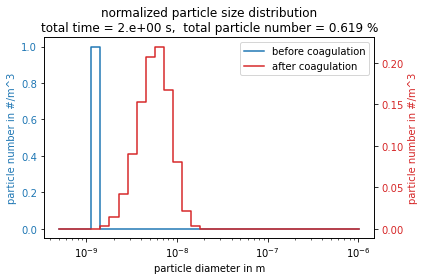

In [25]:
fig, ax1 = plt.subplots()
color1 = "tab:blue"
ax1.semilogx(dp_end, n_0 / np.sum(n_0), drawstyle="steps-mid", \
             label="before coagulation", color = color1) 
ax1.set_ylabel("particle number in #/m^3", color = color1)
ax1.tick_params(axis="y", labelcolor = color1)
title_string = "normalized particle size distribution" + "\n" + \
    "total time = " + \
    str(np.format_float_scientific(t_total, precision=0)) + " s,  " + \
    "total particle number = " + \
    str(round(np.sum(n)/np.sum(n_0),5) * 100) + " %"
ax1.set_title(title_string)
ax1.set_xlabel("particle diameter in m")

color2 = "tab:red"
ax2 = ax1.twinx() 
ax2.semilogx(dp_end, n / np.sum(n), drawstyle="steps-mid", \
             label="after coagulation", color = color2) 
ax2.set_ylabel("particle number in #/m^3", color = color2)
ax2.tick_params(axis="y", labelcolor = color2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.tight_layout()
plt.show()

## Things to try

* Change t_total from 2e-0 to 2e-2 to 2e2 or any other value.
* What happens if t_total becomes too large and why ?
* Change the start_bin from 4 to 8 or any other value.              
* Change the value of the starting number concentration (n_0[start_bin] = 1e18). What happens if it is too large and why? 
* Start with two (or more) start bins such as  
        start_bin = 4 
        n_0[start_bin] = 1e17 
        n_0[8] = 1e17 
        
* Write your own jupyter skript. Try to implement a $\beta$ that is valid in the continuum regime.

## References

Singh, M., Kaur, G., De Beer, T., Nopens, I. "Solution of bivariate aggregation population balance equation: a comparative study", Reaction Kinetics, Mechanisms and Catalysis, 123 (2) 385-401 (2018). 

Nopens, I., Beheydt, D., Vanrolleghem, P.A. "Comparison and pitfalls of different discretised solution methods for population balance models: a simulation study", Computers & Chemical Engineering, 29 (2) 367-377 (2005). 

Lister, J., Smit, D., Hounslow, M. "Adjustable discretized population balance for growth and aggregation", AIChE Journal, 41 (3) 591-603 (1995). 

Hounslow, M., Ryall, R., Marshall, V. "A discretized population balance for nucleation, growth, and aggregation", AIChE journal, 34 (11) 1821-1832 (1988). 